In [1]:
# Python 3.9 required
# Use GPU to speed up embedding matrix calculation. Alternative: download the embedding matrix 
# already calculated by me from 
# https://drive.google.com/file/d/1fJ5rhqI6wBXKLVbQURj7o7ZPhxTxB_4d/view?usp=sharing and place it 
# at the same directory level as this notebook.
# If you want to compute your own embedding matrix use a Google Colab environment with GPU.
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
from typing import Tuple, List, Literal, NewType, Dict
import os
import time

import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
from langchain_text_splitters import RecursiveCharacterTextSplitter

/home/desposito/Entrevistas/hbs-assignment/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Clone the git repo that contains the data and additional information about the dataset
!git clone https://github.com/wayfair/WANDS.git

fatal: destination path 'WANDS' already exists and is not an empty directory.


In [4]:
# Define functions for product search using Tf-IDF
def calculate_tfidf(dataframe):
    """
    Calculate the TF-IDF for combined product name and description.

    Parameters:
    dataframe (pd.DataFrame): DataFrame with product_id, and other product information.

    Returns:
    TfidfVectorizer, csr_matrix: TF-IDF vectorizer and TF-IDF matrix.
    """
    # Combine product name and description to vectorize
    # NOTE: Please feel free to use any combination of columns available, some columns may contain NULL values
    combined_text = dataframe['product_name'] + ' ' + dataframe['product_description']
    vectorizer = TfidfVectorizer()
    # Convert combined_text to list of unicode strings
    tfidf_matrix = vectorizer.fit_transform(combined_text.values.astype('U'))
    return vectorizer, tfidf_matrix

def get_top_products(vectorizer, tfidf_matrix, query, top_n=10):
    """
    Get top N products for a given query based on TF-IDF similarity.

    Parameters:
    vectorizer (TfidfVectorizer): Trained TF-IDF vectorizer.
    tfidf_matrix (csr_matrix): TF-IDF matrix for the products.
    query (str): Search query.
    top_n (int): Number of top products to return.

    Returns:
    list: List of top N product IDs.
    """
    query_vector = vectorizer.transform([query])
    cosine_similarities = cosine_similarity(query_vector, tfidf_matrix).flatten()
    top_product_indices = cosine_similarities.argsort()[-top_n:][::-1]
    return top_product_indices

In [5]:
# Define functions for evaluating retrieval performance
def map_at_k(true_ids, predicted_ids, k=10):
    """
    Calculate the Mean Average Precision at K (MAP@K).

    Parameters:
    true_ids (list): List of relevant product IDs.
    predicted_ids (list): List of predicted product IDs.
    k (int): Number of top elements to consider.
             NOTE: IF you wish to change top k, please provide a justification for choosing the new value

    Returns:
    float: MAP@K score.
    """
    # if either list is empty, return 0
    if not len(true_ids) or not len(predicted_ids):
        return 0.0

    score = 0.0
    num_hits = 0.0

    for i, p_id in enumerate(predicted_ids[:k]):
        if p_id in true_ids and p_id not in predicted_ids[:i]:
            num_hits += 1.0
            score += num_hits / (i + 1.0)

    return score / min(len(true_ids), k)

In [6]:
# Please add any new evaluation functions here
def weighted_map_at_k(
        exact_match_ids: List[int], partial_match_ids: List[int], retrieval_ids: List[int], 
        k: int = 10
) -> float:
    """
    Calculate the Weighted Mean Average Precision at K (Weighted MAP@K).

    Parameters:
    exact_match_ids (list): List of IDs of exact matches.
    partial_match_ids (list): List of IDs of partial matches.
    retrieval_ids (list): List of retrieved IDs, ordered by rank.
    k (int): Number of top elements to consider.

    Returns:
    float: Weighted MAP@K score.
    """
    if not retrieval_ids:
        return 0.0

    score = 0.0
    weighted_num_hits = 0.0
    exact_match_weight = 1.0
    partial_match_weight = 0.5

    seen_ids = set()

    for i, retrieved_id in enumerate(retrieval_ids[:k]):
        weight = 0.0
        if retrieved_id in exact_match_ids:
            weight = exact_match_weight
        elif retrieved_id in partial_match_ids:
            weight = partial_match_weight

        if weight > 0 and retrieved_id not in seen_ids:
            weighted_num_hits += weight
            score += weighted_num_hits / (i + 1.0)
            seen_ids.add(retrieved_id)

    num_exact_relevant = len(set(exact_match_ids))
    num_partial_relevant = len(set(partial_match_ids) - set(exact_match_ids))
    total_relevant_weight = (
        num_exact_relevant * exact_match_weight + num_partial_relevant * partial_match_weight
    )

    if total_relevant_weight == 0:
        return 0.0
    else:
        return score / min(total_relevant_weight, k)

In [7]:
# Get search queries
query_df = pd.read_csv("WANDS/dataset/query.csv", sep='\t')

In [8]:
query_df.head()

,query_id,query,query_class
0,0,salon chair,Massage Chairs
1,1,smart coffee table,Coffee & Cocktail Tables
2,2,dinosaur,Kids Wall Décor
3,3,turquoise pillows,Accent Pillows
4,4,chair and a half recliner,Recliners


In [9]:
# Get products
product_df = pd.read_csv("WANDS/dataset/product.csv", sep='\t')

In [27]:
display(product_df.head())
max_length_to_embed = product_df['product_name'].apply(len).max()
max_length_to_embed += product_df['product_description'].apply(
    lambda x: len(x) if isinstance(x, str) else 0
).max()
display(f'Max length to embed is {max_length_to_embed}')

,product_id,product_name,product_class,category hierarchy,product_description,product_features,rating_count,average_rating,review_count
0,0,solid wood platform bed,Beds,Furniture / Bedroom Furniture / Beds & Headboa...,"good , deep sleep can be quite difficult to ha...",overallwidth-sidetoside:64.7|dsprimaryproducts...,15.0,4.5,15.0
1,1,all-clad 7 qt . slow cooker,Slow Cookers,Kitchen & Tabletop / Small Kitchen Appliances ...,"create delicious slow-cooked meals , from tend...",capacityquarts:7|producttype : slow cooker|pro...,100.0,2.0,98.0
2,2,all-clad electrics 6.5 qt . slow cooker,Slow Cookers,Kitchen & Tabletop / Small Kitchen Appliances ...,prepare home-cooked meals on any schedule with...,features : keep warm setting|capacityquarts:6....,208.0,3.0,181.0
3,3,all-clad all professional tools pizza cutter,"Slicers, Peelers And Graters",Browse By Brand / All-Clad,this original stainless tool was designed to c...,overallwidth-sidetoside:3.5|warrantylength : l...,69.0,4.5,42.0
4,4,baldwin prestige alcott passage knob with roun...,Door Knobs,Home Improvement / Doors & Door Hardware / Doo...,the hardware has a rich heritage of delivering...,compatibledoorthickness:1.375 '' |countryofori...,70.0,5.0,42.0


'Max length to embed is 4317'

In [11]:
# Get manually labeled groundtruth lables
label_df = pd.read_csv("WANDS/dataset/label.csv", sep='\t')

In [28]:
display(label_df.head())
display(f"The testing labels are {label_df['label'].unique()}")

,id,query_id,product_id,label
0,0,0,25434,Exact
1,1,0,12088,Irrelevant
2,2,0,42931,Exact
3,3,0,2636,Exact
4,4,0,42923,Exact


"The testing labels are ['Exact' 'Irrelevant' 'Partial']"

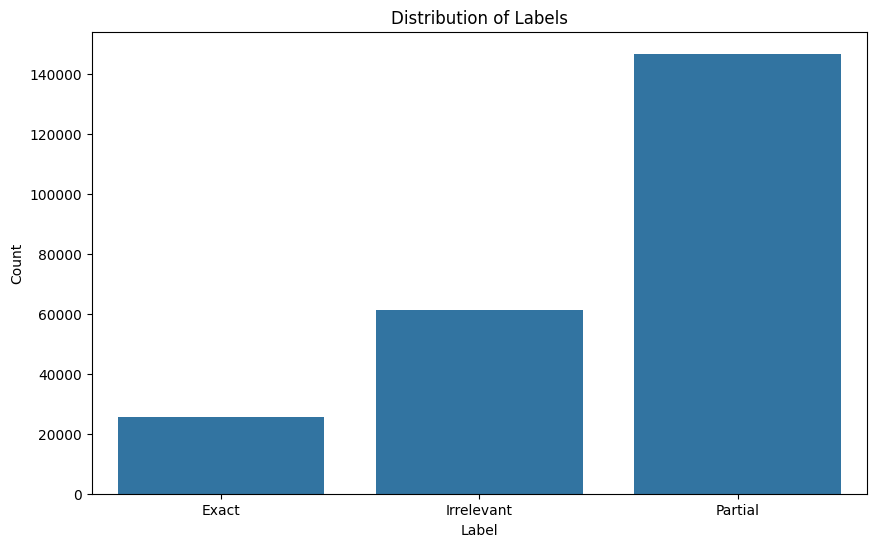

In [29]:
# Plot labels distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='label', data=label_df)
plt.title('Distribution of Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

In [14]:
# Compute label ratios
label_counts = label_df['label'].value_counts()
size = label_df.shape[0]
display(f"Exact {label_counts['Exact']/size}")
display(f"Partial {label_counts['Partial']/size}")
display(f"Irrelevant {label_counts['Irrelevant']/size}")

'Exact 0.10972036599156985'

'Partial 0.6281184674959734'

'Irrelevant 0.26216116651245674'

In [15]:
# Group the labels for each query to use when identifying exact matches
grouped_label_df = label_df.groupby('query_id')

In [16]:
# Calculate TF-IDF
vectorizer, tfidf_matrix = calculate_tfidf(product_df)
display(len(vectorizer.vocabulary_))
display(tfidf_matrix.shape)

44307

(42994, 44307)

In [ ]:
# Implementing a function to retrieve top K product IDs for a query
def get_top_product_ids_for_query(query):
    top_product_indices = get_top_products(vectorizer, tfidf_matrix, query, top_n=10)
    top_product_ids = product_df.iloc[top_product_indices]['product_id'].tolist()
    return top_product_ids

In [17]:
# Sanity check code block to see if the search results are relevant
# Define the test query
query = "armchair"

# Obtain top product IDs
top_product_ids = get_top_product_ids_for_query(query)

print(f"Top products for '{query}':")
for product_id in top_product_ids:
    product = product_df.loc[product_df['product_id'] == product_id]
    print(product_id, product['product_name'].values[0])

Top products for 'armchair':
12756 24.41 '' wide tufted polyester armchair
42698 donham armchair
42697 donham 25 '' wide armchair
41270 almaraz 33.7 '' wide leather match armchair
23907 faizah 27.6 '' wide tufted polyester armchair
31564 biloxi 34.75 '' wide armchair
41306 hartsell 33 '' wide armchair
1527 howington 39 '' wide tufted linen armchair
42802 donham polyester lounge chair
6532 ogan 29 '' wide polyester armchair


In [18]:
# Implementing a function to retrieve exact match product IDs for a query_id
def get_matches_for_query(query_id: str, label: Literal['Exact', 'Irrelevant', 'Partial']) -> List[int]:
    query_group = grouped_label_df.get_group(query_id)
    exact_matches = query_group.loc[query_group['label'] == label]['product_id'].values
    return exact_matches

# Applying the function to obtain top product IDs and adding top K product IDs to the dataframe 
query_df['top_product_ids'] = query_df['query'].apply(get_top_product_ids_for_query)

# Adding the list of exact match product_IDs from labels_df
query_df['exact_match_ids'] = query_df['query_id'].apply(lambda x: get_matches_for_query(x, 'Exact'))
query_df['partial_match_ids'] = query_df['query_id'].apply(lambda x: get_matches_for_query(x, 'Partial'))

# Assign the map@k score
query_df['map@k'] = query_df.apply(
    lambda x: map_at_k(x['exact_match_ids'], x['top_product_ids'], k=10), axis=1
)

# Assign the weighted_map@k score
query_df['weighted_map@k'] = query_df.apply(
    lambda x: weighted_map_at_k(
        x['exact_match_ids'], x['partial_match_ids'], x['top_product_ids'], k=10,
    ), axis=1
)


In [39]:
# Calculate the MAP and Weighted MAP across the entire query set
display('Results of doing a lexical search with TF IDF:')
display(f"MAP at k=10 is {query_df.loc[:, 'map@k'].mean():.2f}")
display(f"Weighted MAP at k=10 is {query_df.loc[:, 'weighted_map@k'].mean():.2f}")

'Results of doing a lexical search with TF IDF:'

'MAP at k=10 is 0.29'

'Weighted MAP at k=10 is 0.46'

In [20]:
ProductID = NewType('ProductID', int)

def calculate_embedding_matrix(
        dataframe: pd.DataFrame
) -> Tuple[SentenceTransformer, np.ndarray, List[ProductID]]:
    """
    Calculate the embedding matrix for product content using SentenceTransformer with the 
    sentence embedding model Snowflake/snowflake-arctic-embed-m. The product content is chunked 
    because there are some products that may exceed the max amount of tokens that the sentence 
    embedding model is able to embed.
    This method is optimized to just run one time, after the first computation of the embedding
    matrix, the data is stored with pickle. Following executions will use the stored embedding 
    matrix.
    Alongside the embedding matrix, a row-aligned list is returned, providing a mapping between 
    the row indices of the embedding matrix and their corresponding product IDs.
    
    Parameters:
    dataframe (pd.DataFrame): DataFrame with product information.
    
    Returns:
    Tuple[SentenceTransformer, np.ndarray, List[ProductID]]: 
        - The SentenceTransformer model
        - Matrix of all embeddings
        - List mapping embedding indices to product IDs
    """
    # Model selection
    model = SentenceTransformer('Snowflake/snowflake-arctic-embed-m', trust_remote_code=True)
    max_tokens = 512
    
    # Check if processed embeddings exist
    if os.path.exists('product_embeddings_matrix.pkl'):
        with open('product_embeddings_matrix.pkl', 'rb') as f:
            saved_data = pickle.load(f)
            return model, saved_data['embedding_matrix'], saved_data['product_id_map']
    
    # Initialize text splitter with 50% overlap
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=max_tokens*3,
        chunk_overlap=(max_tokens*3)//2,  # 50% overlap
        length_function=len,
        separators=["\n\n", "\n", " ", ""]
    )
    
    # Lists to hold all chunks and their corresponding product IDs
    all_chunks = []
    product_id_map = []  # Maps embedding index -> product_id
    
    # Process each product
    for idx, row in dataframe.iterrows():
        product_id = row['product_id']
        combined_text = f"{row['product_name']} {row['product_description']}"
        
        # Split into chunks
        chunks = text_splitter.split_text(combined_text)
        
        # Store chunks and product id
        all_chunks.extend(chunks)
        product_id_map.extend([product_id] * len(chunks))
    
    
    # Convert chunks to embeddings in batches
    batch_size = 256
    embedding_list = []
    
    print(f"Generating embeddings for {len(all_chunks)} chunks in {(len(all_chunks) // batch_size) + 1} batches")
    
    for i in range(0, len(all_chunks), batch_size):
        batch_chunks = all_chunks[i:i+batch_size]
        batch_embeddings = model.encode(batch_chunks, show_progress=False)
        embedding_list.append(batch_embeddings)
        
        if i % (batch_size * 10) == 0 and i > 0:
            print(f"Encoded {i}/{len(all_chunks)} chunks")
    
    # Stack all embeddings into a single matrix
    embedding_matrix = np.vstack(embedding_list)
    
    # Save for future use
    with open('product_embeddings_matrix.pkl', 'wb') as f:
        pickle.dump({
            'embedding_matrix': embedding_matrix, 
            'product_id_map': product_id_map
        }, f)
    
    return model, embedding_matrix, product_id_map


In [21]:
def get_top_products_ids_using_semantic_search(
        model: SentenceTransformer, 
        embedding_matrix: np.ndarray, 
        product_id_map: List[int], 
        query: str, 
        top_n: int = 10
) -> List[ProductID]:
    """
    Get top products using semantic search.
    
    Parameters:
    model: SentenceTransformer model
    embedding_matrix: Matrix containing all chunk embeddings
    product_id_map: List mapping embedding indices to product IDs
    query: Search query
    top_n: Number of top products to return
    
    Returns:
    List of top product IDs
    """
    # Encode query
    query_embedding = model.encode([query], prompt_name="query")[0]
    
    # Calculate cosine similarity between query and all embeddings
    similarities = cosine_similarity(
        query_embedding.reshape(1, -1),
        embedding_matrix
    )[0]
    
    # Create a mapping of product IDs to their highest similarity scores
    product_similarities = {}
    for idx, similarity in enumerate(similarities):
        product_id = product_id_map[idx]
        current_max = product_similarities.get(product_id, -1)
        product_similarities[product_id] = max(current_max, similarity)
    
    # Sort products by similarity and return top_n
    sorted_products = sorted(
        product_similarities.items(),
        key=lambda x: x[1],
        reverse=True
    )
    
    return [product_id for product_id, _ in sorted_products[:top_n]]

In [22]:
embedding_model, embedding_matrix, product_id_map = calculate_embedding_matrix(product_df)

/home/desposito/Entrevistas/hbs-assignment/.venv/lib/python3.9/site-packages/torch/cuda/__init__.py:129: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


In [23]:
query_df['semantic_search_top_product_ids'] = query_df['query'].apply(
    lambda query: get_top_products_ids_using_semantic_search(
        embedding_model, embedding_matrix, product_id_map, query, top_n=10
    )
)

In [24]:
# Assign the map@k score
query_df['semantic_map@k'] = query_df.apply(
    lambda x: map_at_k(x['exact_match_ids'], x['semantic_search_top_product_ids'], k=10), axis=1
)

# Assign the weighted_map@k score
query_df['semantic_weighted_map@k'] = query_df.apply(
    lambda x: weighted_map_at_k(
        x['exact_match_ids'], x['partial_match_ids'], x['semantic_search_top_product_ids'], k=10,
    ), axis=1
)

In [40]:
display('Results of doing a semantic search with a sentence embedding model are:')
display(f"MAP at k=10 is {query_df.loc[:, 'semantic_map@k'].mean():.2f}")
display(f"Weighted MAP at k=10 is {query_df.loc[:, 'semantic_weighted_map@k'].mean():.2f}")

'Results of doing a semantic search with a sentence embedding model are:'

'MAP at k=10 is 0.45'

'Weighted MAP at k=10 is 0.58'